In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)
%matplotlib inline

In [3]:
'''
somehow we need to get RNA data...
'''
from eden.converter.fasta import fasta_to_sequence
from eden.converter.rna.rnafold import rnafold_to_eden
import graphlearn.abstract_graphs.rnasampler as rspl
from eden.graph import Vectorizer

def rfam_uri(family_id):
    return '%s.fa'%(family_id)
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)


def get_graphs(rfam_id = 'RF00005'):
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    graphs = rnafold_to_eden(seqs, shape_type=5, energy_range=30, max_num=3)
    return graphs


vectorizer=Vectorizer()

def get_directed_graphs(rfam_id = 'RF00005'):
    for g in get_graphs(rfam_id):
        g=vectorizer._edge_to_vertex_transform(g)
        yield rspl.expanded_rna_graph_to_digraph(g)



Starting new HTTP connection (1): rfam.xfam.org
"GET /family/RF00005/alignment?acc=RF00005&format=fastau&download=0 HTTP/1.1" 200 90476


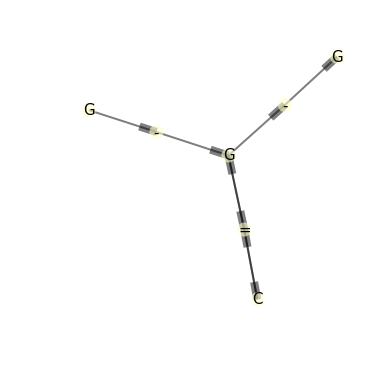

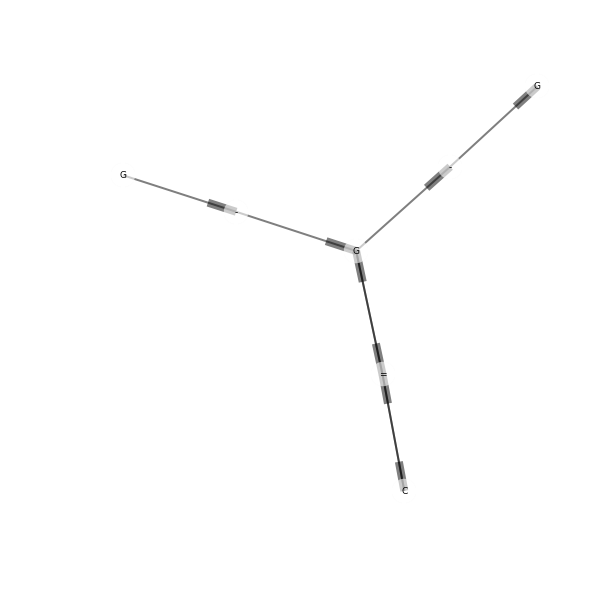

In [17]:
'''
1. MAKE SURE THAT WE CAN EXTRACT DIRECTED CIPS
'''
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import numpy as np
from eden.util.display import draw_graph

#get a graph
graphs = get_directed_graphs()
graph=graphs.next()


def mark_and_draw(cip):
    graph=myutils.cip_to_graph(cip)
    myutils.draw_graph_set_graphlearn(graph, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
radius_list=[0,2]
thickness_list=[2,4]
cip=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list)
#mark_and_draw(cip)
myutils.display(  cip[0].graph, contract=False)
draw_graph(cip[0].graph,edge_label=None)

In [19]:
%%time
'''
getting the grammar is the same as in the UberSampler so there is nothing interesting here..
if you need to debug do so in the UberSampler
'''
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.abstract_graphs.rnasampler as rspl
import itertools
import graphlearn.localsubstitutablegraphgrammar as grammar


# learn a grammar
graphs = get_directed_graphs()
graphs = itertools.islice(graphs,100)
sampler=rspl.RNASampler(radius_list=[0,1,2],thickness_list=[2],base_thickness_list=[0.5,1], cip_remove_threshold=1, interface_remove_threshold=2)
sampler.fit(graphs,n_jobs=4,batch_size=3)
sampler.save('tmp/rna_ubergrammar.ge')



Starting new HTTP connection (1): rfam.xfam.org
"GET /family/RF00005/alignment?acc=RF00005&format=fastau&download=0 HTTP/1.1" 200 90476

Classifier:
SGDClassifier(alpha=0.000838428966957, average=False, class_weight=None,
       epsilon=0.1, eta0=0.475435193629, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=6, n_jobs=1,
       penalty='l1', power_t=0.569327388688, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
Saved model: tmp/rna_ubergrammar.ge
CPU times: user 1min 31s, sys: 13.9 s, total: 1min 44s
Wall time: 3min 55s


interface: 950296


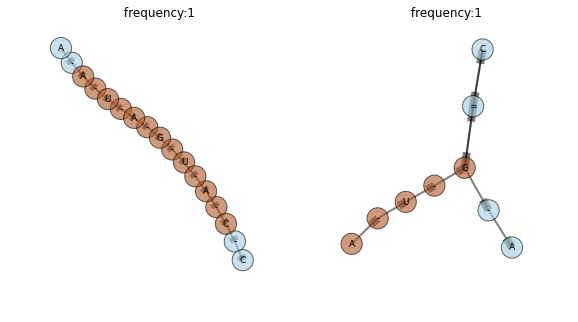

interface: 65561


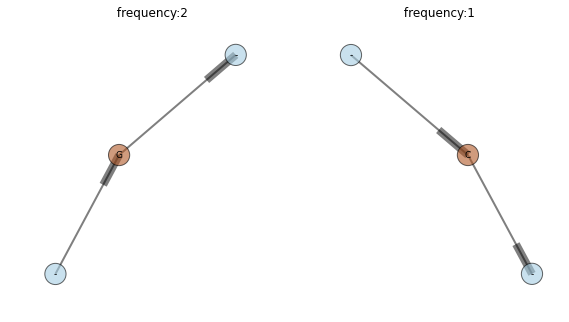

interface: 950313


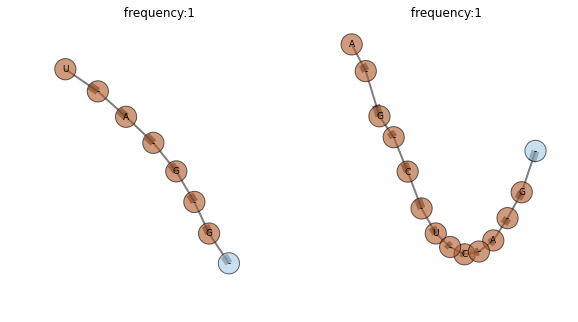

interface: 655407


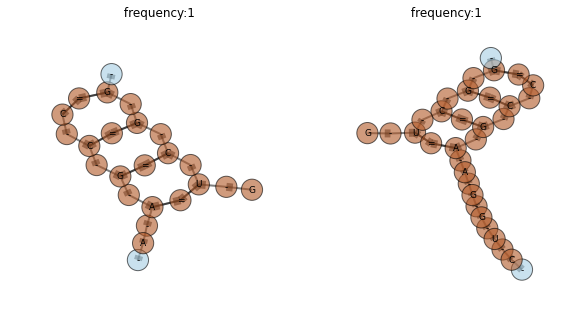

interface: 32832


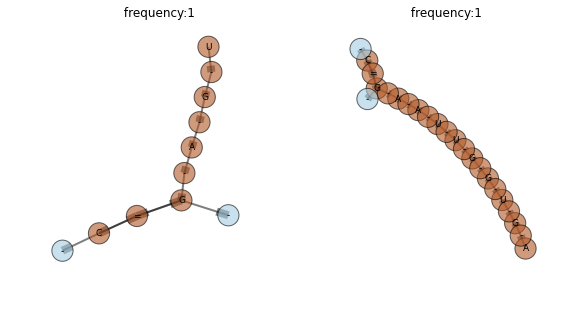

In [22]:
#draw production rules
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,n_productions=5,
                     n_graphs_per_line=6, size=5, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450)

    

Loaded model: tmp/rna_ubergrammar.ge
preprocessing grammar
_sample_notes: None
accept_annealing_factor: 0.0
accept_static_penalty: 0.0
base_thickness_list: [1, 2]
batch_size: 1
   burnout: 0
complexity: 3
 estimator: CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000838428966957, average=False, class_weight=None,
       epsilon=0.1, eta0=0.475435193629, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=6, n_jobs=1,
       penalty='l1', power_t=0.569327388688, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=2, method='sigmoid')
estimatorobject: <graphlearn.estimator.estimator instance at 0x7fe0dc99c3f8>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7fe0dc99c368>
generatormode: False
hash_bitmask: 1048575
keep_duplicates: True
local_substitutable_graph_grammar: <graphlearn.abstract_graphs.ubergraphlearn.UberGrammar object at 0x7fe1040b3990>
    n_jobs: 1
   n_steps: 50
 

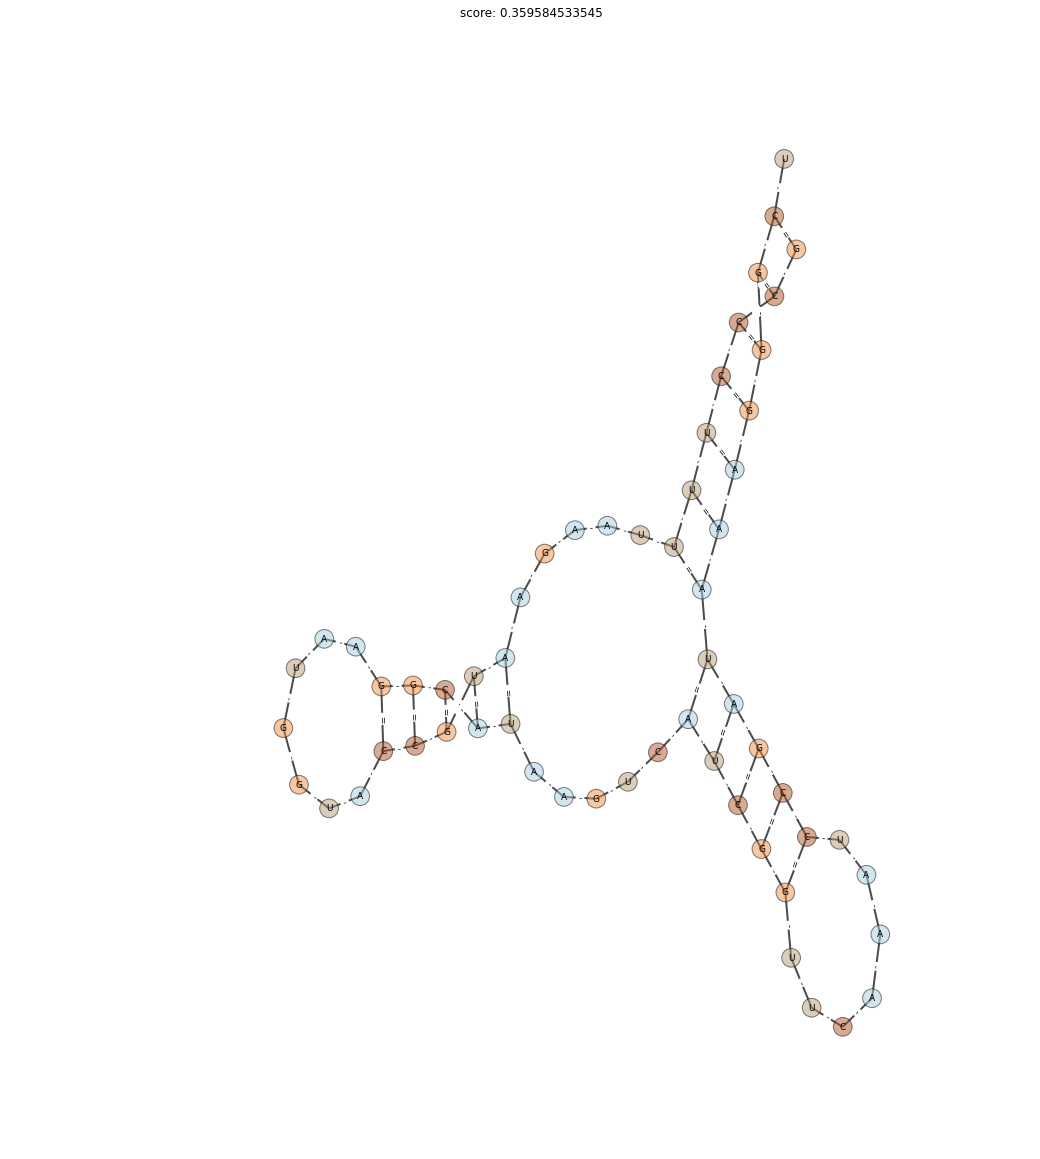

iteration:0
Working with 4 cores
iteration:1
Working with 4 cores
iteration:2
Working with 2 cores
iteration:3
Working with 4 cores
iteration:4
Working with 4 cores
iteration:5
Working with 4 cores
iteration:6
Working with 3 cores
iteration:7
Working with 4 cores
iteration:8
Working with 7 cores
iteration:9
Working with 2 cores
iteration:10
Working with 2 cores
iteration:11
Working with 7 cores
iteration:12
Working with 2 cores
iteration:13
Working with 2 cores
iteration:14
Working with 7 cores
iteration:15
Working with 2 cores
iteration:16
Working with 3 cores
iteration:17
Working with 4 cores
iteration:18
Working with 2 cores
iteration:19
Working with 2 cores
iteration:20
Working with 2 cores
iteration:21
Working with 2 cores
iteration:22
Working with 4 cores
iteration:23
Working with 4 cores
iteration:24
Working with 6 cores
iteration:25
Working with 4 cores
iteration:26
Working with 4 cores
iteration:27
Working with 2 cores
iteration:28
Working with 2 cores
iteration:29
Working wit

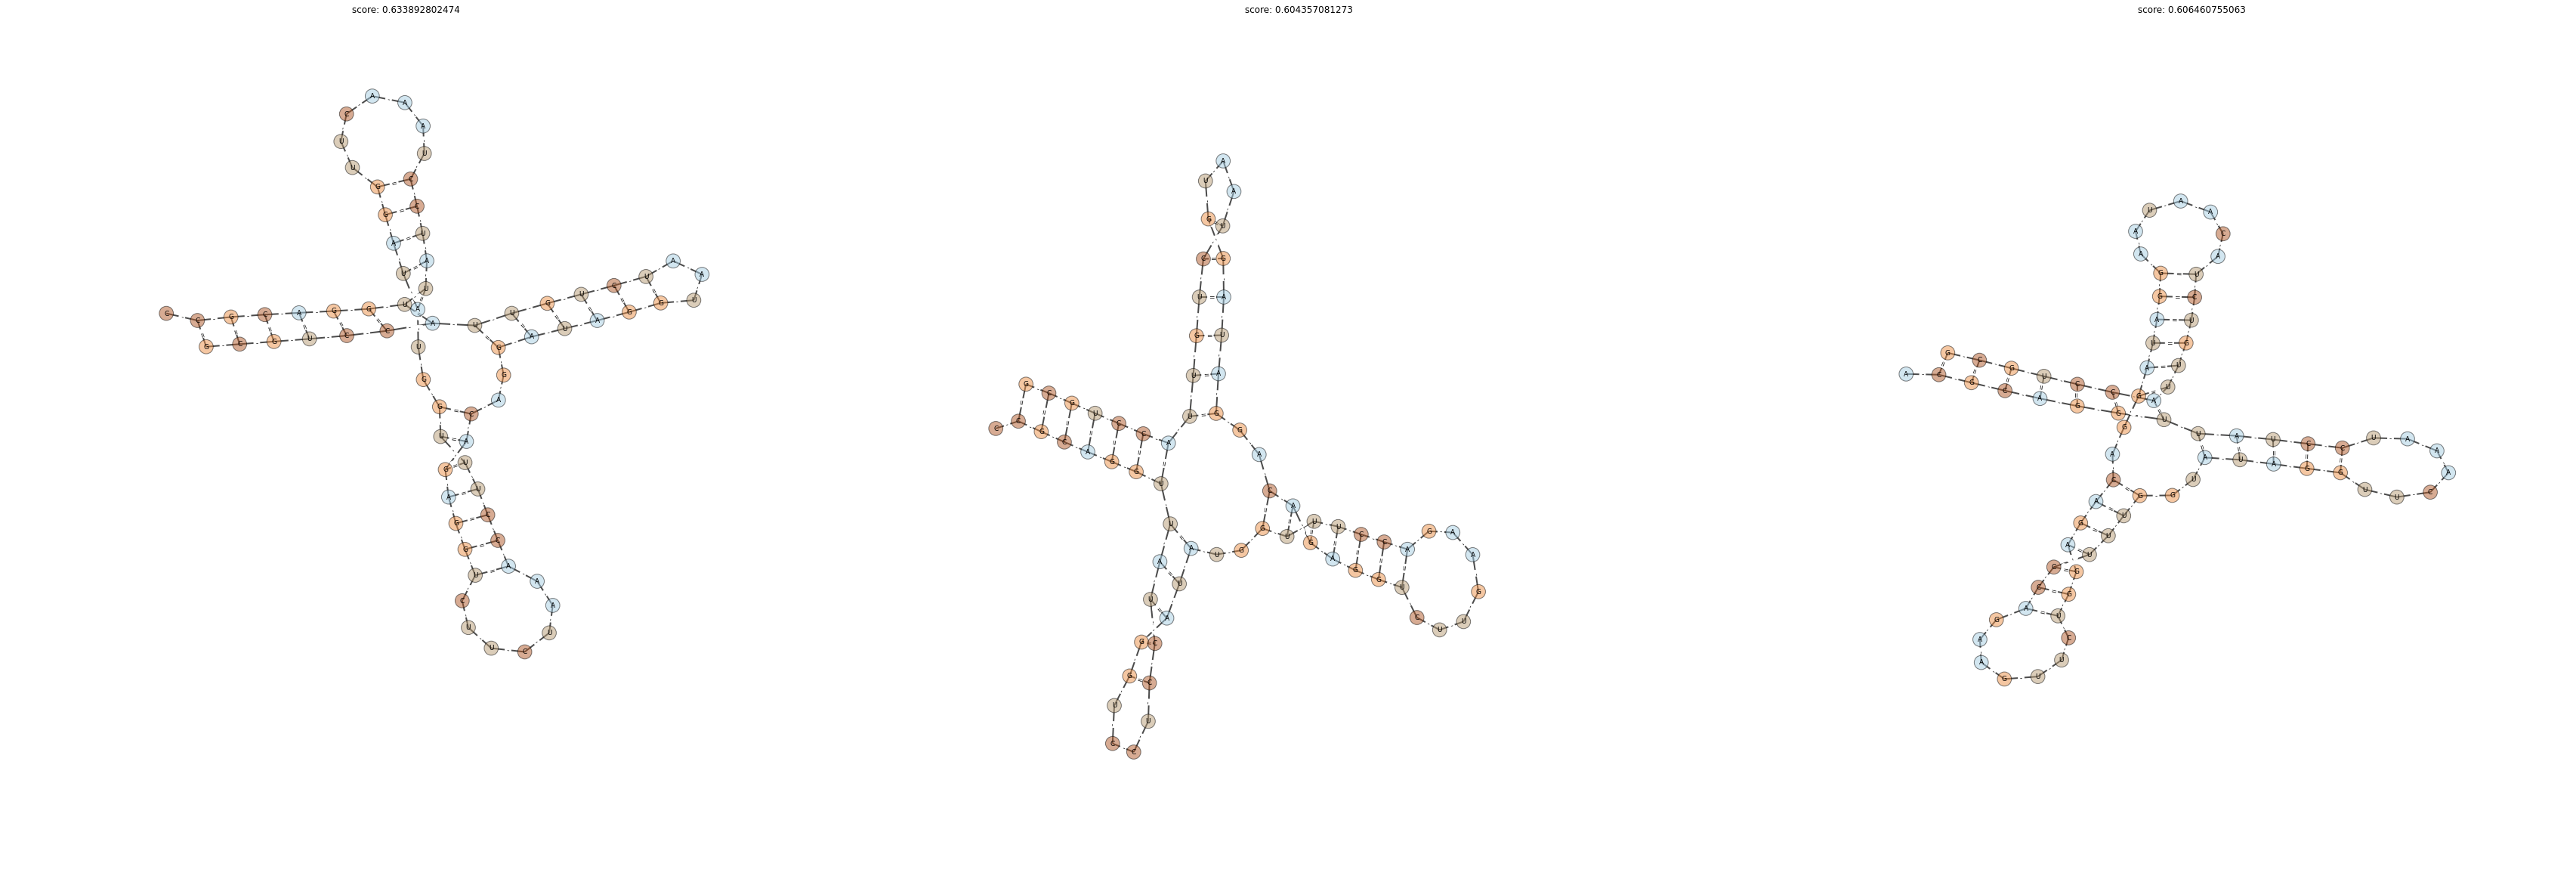

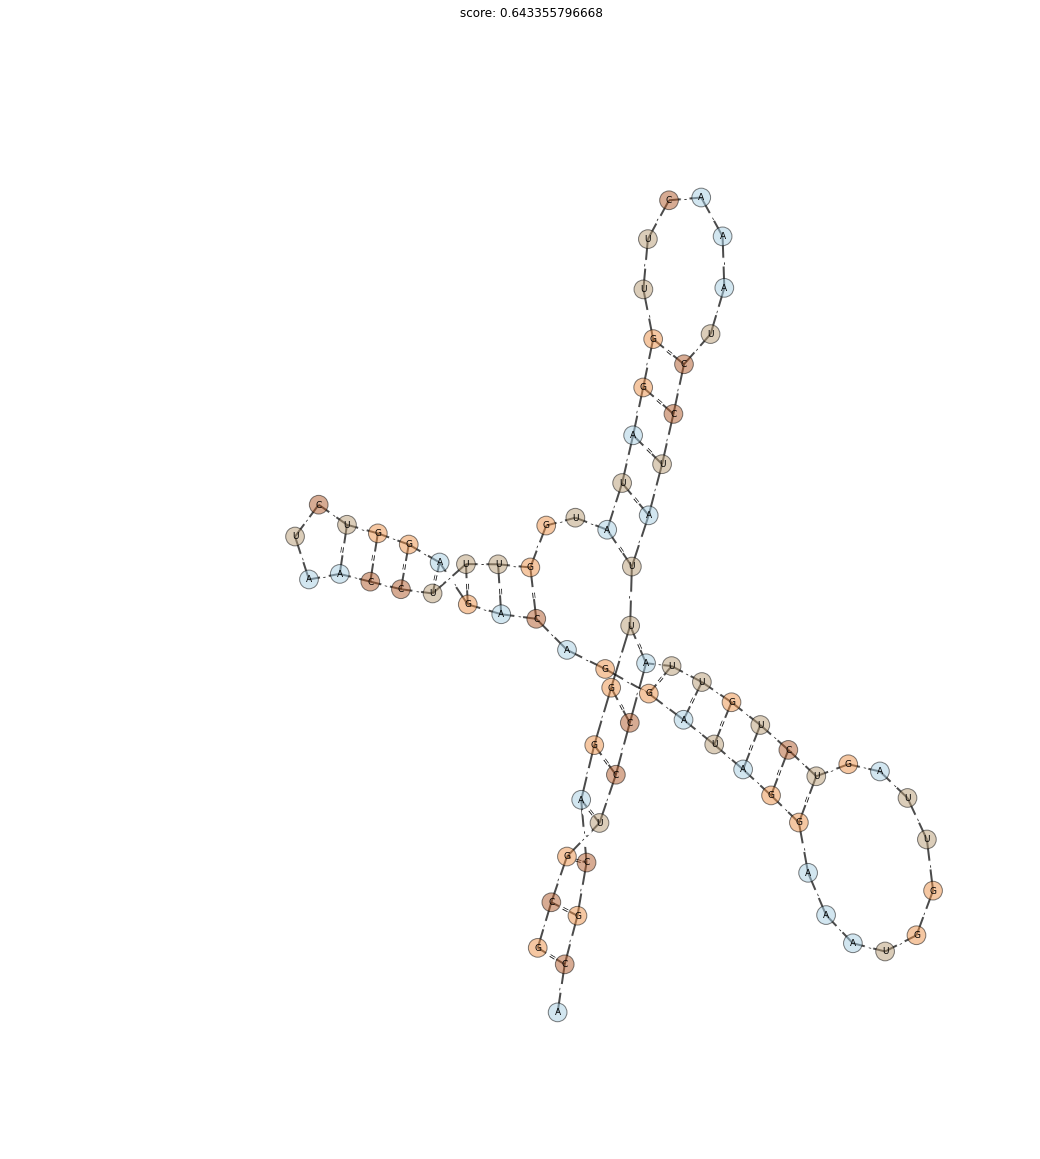

iteration:0
Working with 2 cores
iteration:1
Working with 3 cores
iteration:2
Working with 2 cores
iteration:3
Working with 3 cores
iteration:4
Working with 7 cores
iteration:5
Working with 6 cores
iteration:6
Working with 2 cores
iteration:7
Working with 3 cores
iteration:8
Working with 6 cores
iteration:9
Working with 2 cores
iteration:10
Working with 2 cores
iteration:11
Working with 7 cores
iteration:12
Working with 2 cores
iteration:13
Working with 2 cores
iteration:14
Working with 2 cores
iteration:15
Working with 2 cores
iteration:16
Working with 7 cores
iteration:17
Working with 7 cores
iteration:18
Working with 2 cores
iteration:19
Working with 7 cores
iteration:20
Working with 2 cores
iteration:21
Working with 2 cores
iteration:22
Working with 2 cores
iteration:23
Working with 2 cores
iteration:24
Working with 8 cores
iteration:25
Working with 8 cores
iteration:26
WE CREATED THE ANTI RNA
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 235, in _sampl

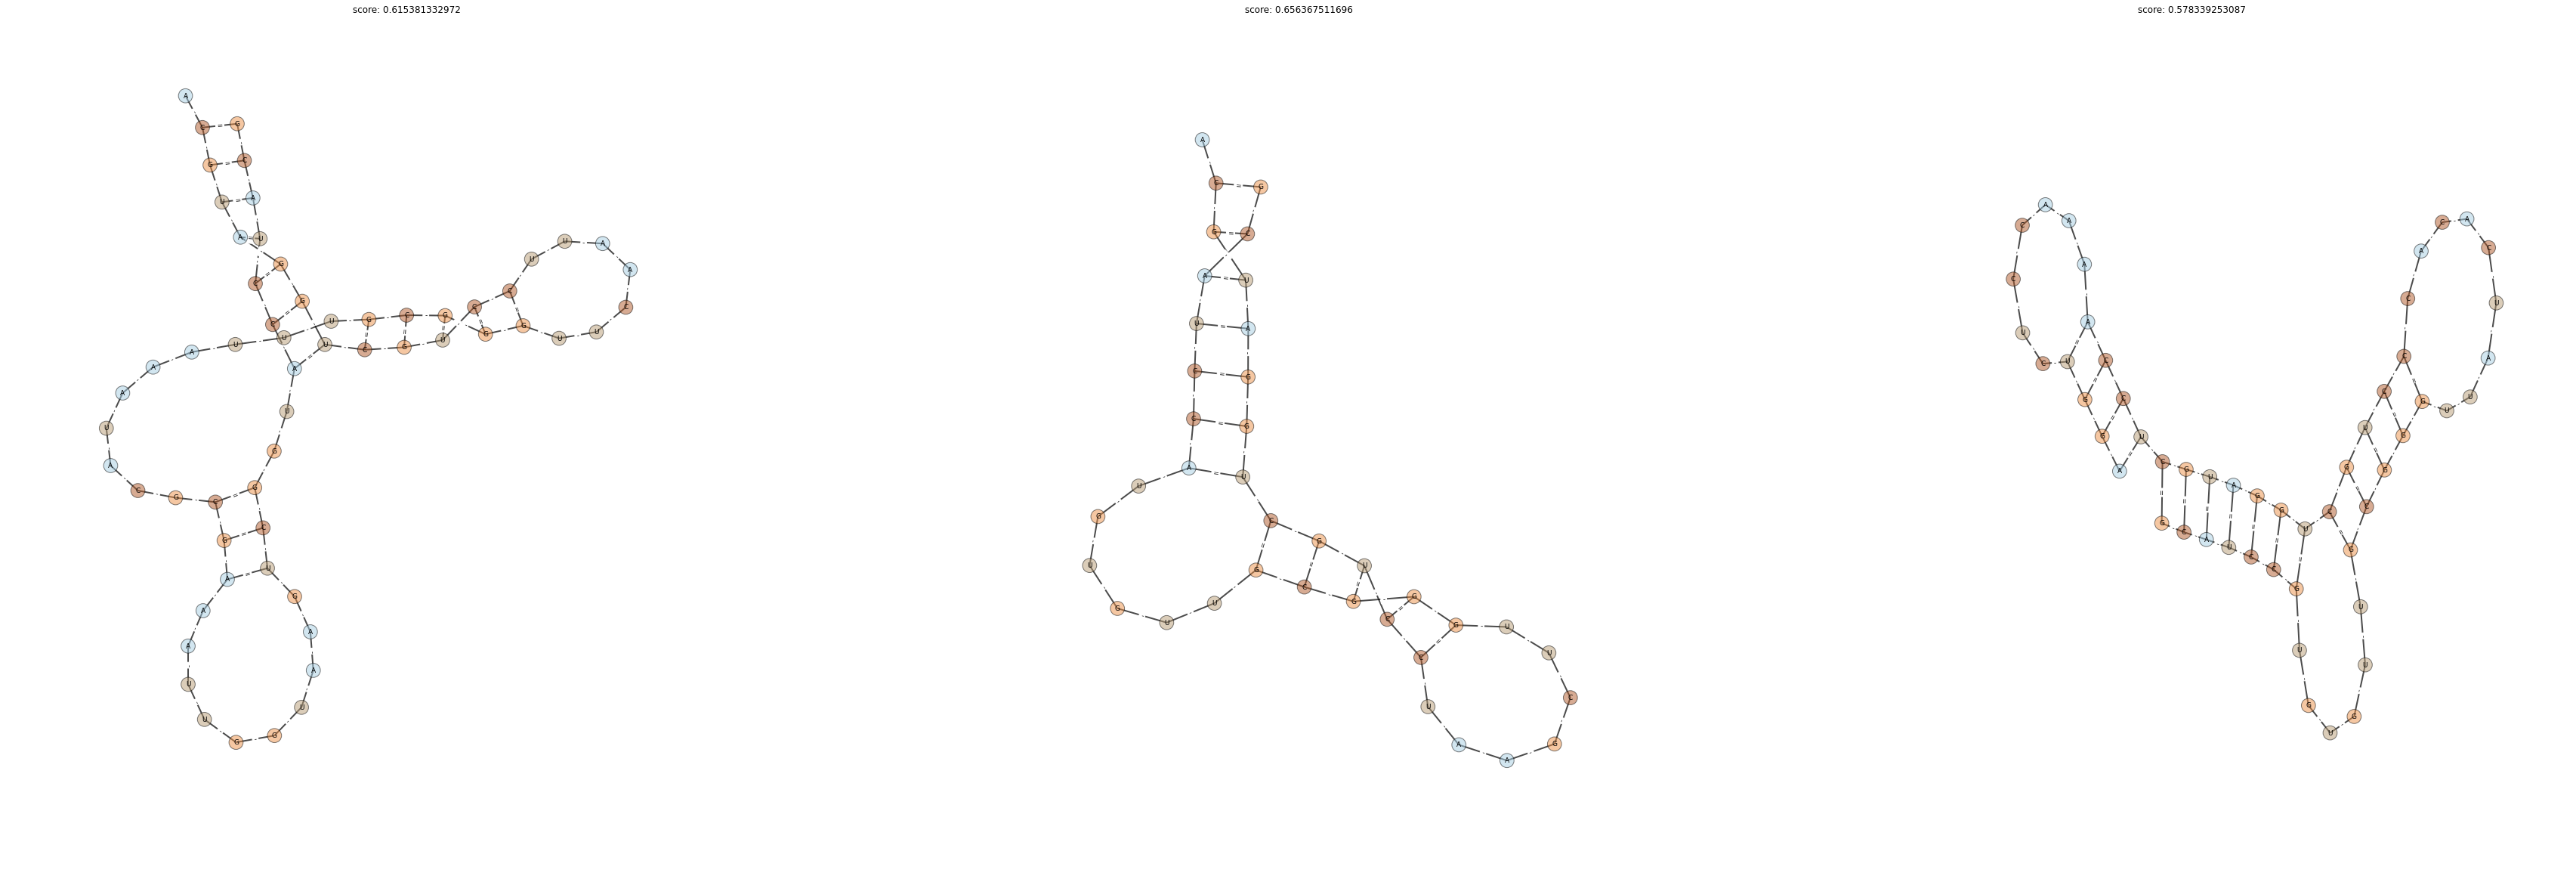

CPU times: user 1min 13s, sys: 3.04 s, total: 1min 17s
Wall time: 1min 23s


In [37]:
%%time
'''
RNA sampling
'''
import os
os.nice(19)

#import mpld3
#mpld3.enable_notebook()
import graphlearn.utils.draw as myutils
import graphlearn.abstract_graphs.rnasampler as rspl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt
import graphlearn.utils.draw as myutils
import eden.graph as ge

sampler=rspl.RNASampler()
sampler.load('tmp/rna_ubergrammar.ge')
graphs = get_graphs()

id_start=15
id_end=id_start+3
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50

graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=False,
                        n_samples=4,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        accept_annealing_factor=0.0,
                        probabilistic_core_choice=True,
                        burnout=0,
                        select_cip_max_tries=200,
                        keep_duplicates=True)

from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['A','U','G','C'])
    myutils.draw_graph_set(path_graphs,
                           n_graphs_per_line=3, size=20, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=350,edge_label='label',
                          headlinehook= myutils.get_score_of_graph
                          )
    

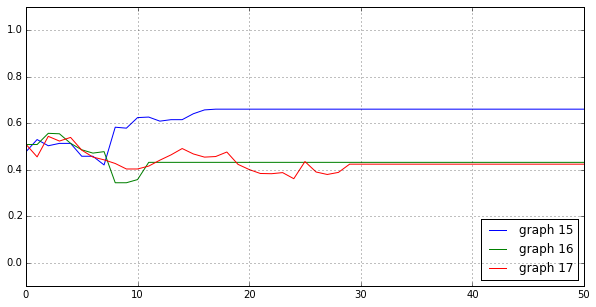

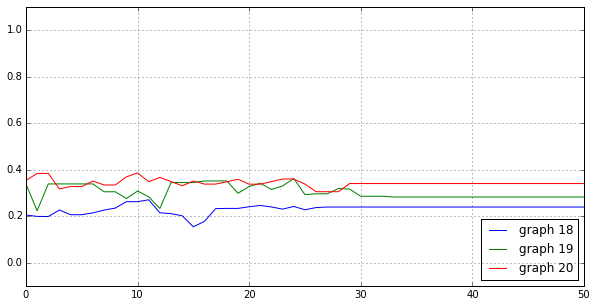

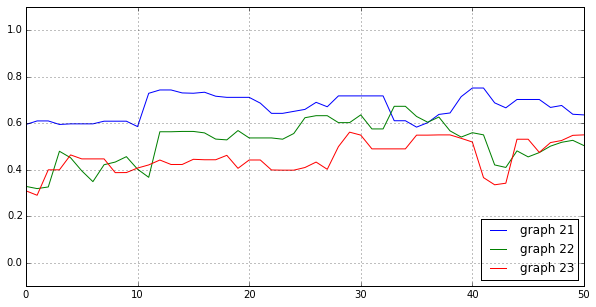

In [10]:
%matplotlib inline
from itertools import islice
import numpy as np

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

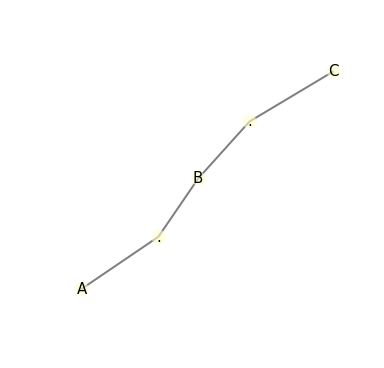

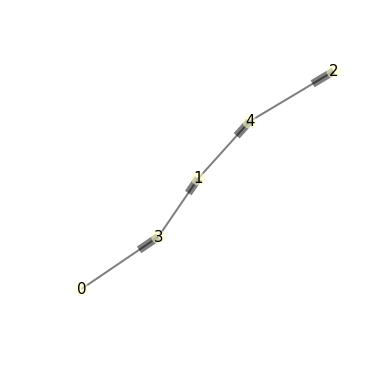

0 [3]
1 [4]
2 []
3 [1]
4 [2]
True


In [35]:

import networkx as nx
import graphlearn.utils.draw as draw
from eden.graph import Vectorizer

v=Vectorizer()
def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

g=getpathgraph("ABC")

g= v._edge_to_vertex_transform(g)

draw.display(g,contract=False)

g2=nx.DiGraph(g)
#draw.display(g2,contract=False,vertex_label='id')

for n,d in g2.nodes(data=True):
    if 'edge' in d:
        if d['label']=='.':
            ns=g2.neighbors(n)
            g2.remove_edge(ns[1],n)
            g2.remove_edge(n,ns[0])
          
       
#g2 = g2.to_undirected()
draw.display(g2,contract=False,vertex_label='id')
g2.edges()
for n in g2.nodes():
    print n,g2.neighbors(n)
print isinstance(g2, nx.DiGraph) 

In [3]:
g2

In [5]:
asd = g2.subgraph(range(2)).copy()

In [6]:
asd